# <center>Sales Simulation with Customer-Level Bahavior and Preference; Regional Seasonality; and Product, Category, and Brand Data</center>
<center>by Nigel Story</center>

## Introduction

I cut my teeth in the retail world - analyzing churn and LTV, identifying real estate opportunities for store deployments, optimizing margin, etc. - so I've often wanted to work on personal projects that use retail data. I started searching, and it turns out that retail companies are not so eager to share their data (understandably so), so I've embarked on a mission to create my own.

Meet __Naturals Retailer__, your one-stop shop for soaps, lotions, and suppliments, and the official retailer of brands like "Bill's Soap Co." and "Treesap Naturals"!

This simulation will revolve around the idea that the trends and patterns observed in retail analytics have their roots in individual customer decisions and behaviors. Therefore, our primary simulated object will be the customers themselves. This will allow us to see high-level metrics, like total seasonal sales, all the way down to micro-level "customer x likes to buy product y". If you want to see how things turn out, check out the <a href="https://app.powerbi.com/view?r=eyJrIjoiZDNjMWY4ZmEtY2Y2Yi00NTMzLTlmZmYtZWM3NjkxOTY0YzRkIiwidCI6ImI1ZjZhZGJmLTVjY2YtNGJlMi04MDgzLWQ4ODY5YjBhNWE0MiIsImMiOjF9&pageName=ReportSection534c763a552cd144ea70">Power BI dashboard</a> that uses data from this simulation.

Now let's get going!

### Packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline

## Product Information Tables

The first step is build our business - "Natural Retailers." I've created product categories, brands, and products for our simulated business to sell. Each product has a brand, category, msrp, and unit cost associated with it, which will allow us to do the majority of classic retail KPI tracking.

In [3]:
categories = [
    {'id': 1, 'descr': 'Soap'},
    {'id': 2, 'descr': 'Lotion'},
    {'id': 3, 'descr': 'Supplement'}
]

brands = [
    {'id': 1, 'descr': "Bill's Soap Co."},
    {'id': 2, 'descr': "Taysha's Health & Wellness"},
    {'id': 3, 'descr': "Treesap Naturals"}
]

In [2]:
products = [
    {'id': 1, 'descr': 'Gentle Soap', 'msrp': 10.00, 'unit_cost': 5.00, 'brand': 1, 'category': 1},
    {'id': 2, 'descr': 'Rejuvinating Soap', 'msrp': 12.00, 'unit_cost': 6.00, 'brand': 1, 'category': 1},
    {'id': 3, 'descr': 'Moisturizing Lotion', 'msrp': 12.00, 'unit_cost': 6.00, 'brand': 1, 'category': 2},
    {'id': 4, 'descr': 'All Clean Hand Soap', 'msrp': 11.00, 'unit_cost': 6.60, 'brand': 2, 'category': 1},
    {'id': 5, 'descr': 'All Clean Hand Lotion', 'msrp': 11.00, 'unit_cost': 6.60, 'brand': 2, 'category': 2},
    {'id': 6, 'descr': 'Hempy Hand Lotion', 'msrp': 13.00, 'unit_cost': 7.80, 'brand': 2, 'category': 2},
    {'id': 7, 'descr': 'Hempy Health Supplements', 'msrp': 15.00, 'unit_cost': 9.00, 'brand': 2, 'category': 3},
    {'id': 8, 'descr': 'Natural Cedar Lotion', 'msrp': 12.00, 'unit_cost': 6.00, 'brand': 3, 'category': 2},
    {'id': 9, 'descr': 'Natural Extract', 'msrp': 15.00, 'unit_cost': 7.50, 'brand': 3, 'category': 3},
    {'id': 10, 'descr': 'Natural Energy', 'msrp': 14.00, 'unit_cost': 7.00, 'brand': 3, 'category': 3}  
]

In [4]:
products = pd.DataFrame(products)
categories = pd.DataFrame(categories)
brands = pd.DataFrame(brands)

vi_products = pd.merge(left=products, right=brands, left_on='brand', right_on='id', how='inner', suffixes=('', '_brand'))
vi_products = pd.merge(left=vi_products, right=categories, left_on='category', right_on='id', how='inner', suffixes=('', '_categ'))
vi_products.drop(['id_categ', 'id_brand'], axis=1, inplace=True)
vi_products.head()

,brand,category,descr,id,msrp,unit_cost,descr_brand,descr_categ
0,1,1,Gentle Soap,1,10.0,5.0,Bill's Soap Co.,Soap
1,1,1,Rejuvinating Soap,2,12.0,6.0,Bill's Soap Co.,Soap
2,2,1,All Clean Hand Soap,4,11.0,6.6,Taysha's Health & Wellness,Soap
3,1,2,Moisturizing Lotion,3,12.0,6.0,Bill's Soap Co.,Lotion
4,2,2,All Clean Hand Lotion,5,11.0,6.6,Taysha's Health & Wellness,Lotion


##  Customer Names

Next, we need customers! Or at least, names to give them. We'll use the top 50 male and female names listed on the SSA website below, along with the most common U.S. surnames listed on thoughtco.com.

In [5]:
# baby names url
url = "https://www.ssa.gov/oact/babynames/decades/century.html"
res = requests.get(url)
if res.status_code==200:
    soup = BeautifulSoup(res.text)

In [6]:
rows = soup.find('table').find('tbody').find_all('tr')
rows[:5]

[<tr align="right"><td>1</td>
 <td>James</td> <td>4,700,229</td> <td>Mary</td> <td>3,196,385</td></tr>,
 <tr align="right"><td>2</td>
 <td>Robert</td> <td>4,455,696</td> <td>Patricia</td> <td>1,558,407</td></tr>,
 <tr align="right"><td>3</td>
 <td>John</td> <td>4,453,807</td> <td>Jennifer</td> <td>1,468,377</td></tr>,
 <tr align="right"><td>4</td>
 <td>Michael</td> <td>4,335,919</td> <td>Linda</td> <td>1,448,303</td></tr>,
 <tr align="right"><td>5</td>
 <td>William</td> <td>3,564,276</td> <td>Elizabeth</td> <td>1,420,377</td></tr>]

In [7]:
names = []
for r in rows:
    data = r.find_all('td')
    try:
        names.append((data[1].text, data[3].text))
    except IndexError as e:
        continue

In [8]:
len(names)

100

In [9]:
male_names = [x[0] for x in names]
female_names = [x[1] for x in names]

In [10]:
# last names url
last_url = "https://www.thoughtco.com/most-common-us-surnames-1422656"
res = requests.get(last_url)
if res.status_code==200:
    soup = BeautifulSoup(res.text)

In [11]:
rows = soup.find('table').find('tbody').find_all('tr')
rows[0]

<tr>
<td><p>1</p></td>
<td><p><a data-component="link" data-ordinal="1" data-source="inlineLink" data-type="internalLink" href="https://www.thoughtco.com/smith-name-meaning-and-origin-1422624">Smith</a></p></td>
<td><p><a data-component="link" data-ordinal="1" data-source="inlineLink" data-type="internalLink" href="https://www.thoughtco.com/english-surnames-meanings-and-origins-1422405">English</a></p></td>
<td><p>2,442,977</p></td>
</tr>

In [12]:
last_names = []
for r in rows:
    try:
        last_names.append(r.find_all('a')[0].text)
    except IndexError as e:
        continue

In [13]:
len(last_names)

93

## State Names

The customers gotta live somewhere! Rather than listing out the 50 states myself, a much faster option is to scrape them from the web. This way, we also gain access to states' U.S. region names and divisions.

In [14]:
states_url = "https://raw.githubusercontent.com/cphalpert/census-regions/master/" + \
"us%20census%20bureau%20regions%20and%20divisions.csv"

In [15]:
res = requests.get(states_url)
if res.status_code == 200:
    states_csv = StringIO(res.text)

In [16]:
states_df = pd.read_csv(states_csv, sep=',')

In [17]:
states_df.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [18]:
state_names = states_df['State Code'].tolist()

In [19]:
states_df.Region.unique()

array(['West', 'South', 'Northeast', 'Midwest'], dtype=object)

In [20]:
states_df.loc[states_df['State Code']=='NY', 'Region'].values[0]

'Northeast'

## Seasonality

Here's where the heavy lifting starts. We will need to be able to define customers' shopping behaviors, and fundamental to that is the concept of seasonality. 

We're going to make a shopper's seasonality dependent on their region. For instance, the weather in California permits shoppers to shop year-round, whereas a shopper in the Notheast might have trouble driving to the store in winter. We're also going to account somewhat for the holiday's (a spike in November from Black Friday) and other seasonal "bumps."

Each `Seasonality` object will have a seasonal CDF distribution that will allow for the use of the inverse transform method during simulation.

In [21]:
class Seasonality:
    
    def __init__(self, state_code):
        self._seasonality_lookup = {
            'Northeast': [.2, .5, .1, .2, .5, .3, .6, .4, .2, .1, 1, .7], # Jan - Dec
            'South': [0, .3, .1, .4, .6, .5, .6, .4, .1, .2, .8, .8],
            'Midwest': [.3, .4, .1, 0, .3, .7, .8, .5, .4, .2, .9, .5],
            'West': [.3, .4, .2, .1, .1, .2, .4, .6, .7, .3, .6, .5]
        }
        
        self._seasonal_region = states_df.loc[states_df['State Code']==state_code, 'Region'].values[0]   
        self._seasonal_weights = self._seasonality_lookup[self._seasonal_region]
        self._seasonal_rands = [max(np.random.normal(loc=x, scale=0.15), 0) for x in self._seasonal_weights]
        
        rand_tot = sum(self._seasonal_rands)
        
        self.seasonal_behavior = [x/rand_tot for x in self._seasonal_rands]
        self.seasonal_cdf = list(self.gen_seasonal_cdf())
        
        
    def gen_seasonal_cdf(self):
        tot = 0
        for item in self.seasonal_behavior:
            tot += item
            yield tot
        

In [22]:
s = Seasonality('LA')
s.seasonal_cdf

[0.0,
 0.08038717429904645,
 0.08908918613882683,
 0.12775004982443108,
 0.275905013071287,
 0.3714544547212645,
 0.4951129897309958,
 0.6013277733455649,
 0.6337004959143787,
 0.6993555114536002,
 0.8198215622555375,
 0.9999999999999999]

## Customer and Behavior Classes

Next, we'll need a class to determine the behavior of an individual customer. Each customer will have shopping frequencies, spending distributions, seasonalities, and brand and category preferences that will be initialized upon their instanciation. These will be created by a `Behavior` class.

The `Behavior` class will also create segmenting behaviors between male and female customers, though the customer's sex will be omitted from the final dataset. This will allow for analytists to explore these differences with unsupervised methods.

In [23]:
class Behavior:
    
    def __init__(self):
        self.frequency = 0
        self.avg_spend = 0
        self.std_spend = 0
        self.seasonality = None
        self.brand_weights = {
            1: 0,
            2: 0,
            3: 0
        }
        self.category_weights = {
            1: 0,
            2: 0,
            3: 0
        }
        self.seasonal_cdf = []
        
        
    def cum_sum(self, ls):
        tot = 0
        for item in ls:
            tot += item
            yield tot
        
        
    def init_brand_weights(self, customer):
        if customer.gender == 'Male':
            pref = [.4, .1, .3]
        else:
            pref = [.5, .4, .3]
            
        rands = np.random.rand(1,3) + pref
        weights = rands / rands.sum()
        weights = list(weights[0])
        cdf = [x for x in self.cum_sum(weights)]
        for i in range(len(cdf)):
            self.brand_weights[i+1] = cdf[i]
    
    
    def init_category_weights(self, customer):
        if customer.gender == 'Male':
            pref = [.3, .5, 1]
        else:
            pref = [.3, .8, 1]
            
        rands = np.random.rand(1,3) + pref
        weights = rands / rands.sum()
        weights = list(weights[0])
        cdf = [x for x in self.cum_sum(weights)]
        for i in range(len(cdf)):
            self.category_weights[i+1] = cdf[i]
            
    
    def init_seasonal_cdf(self, customer):
        self.seasonality = Seasonality(customer.state)
        self.seasonal_cdf = self.seasonality.seasonal_cdf
    
        
    def fit(self, customer):
        # create variance between sex
        if customer.gender == 'Male':
            self.avg_spend = max(np.random.normal(loc=23, scale=12.5), 10)
            self.std_spend = max(np.random.normal(loc=8, scale=3), 2)
            self.frequency = max(np.random.normal(loc=3, scale=3), 1)
            
        else:
            self.avg_spend = max(np.random.normal(loc=27, scale=14), 10)
            self.std_spend = max(np.random.normal(loc=5, scale=2), 2)
            self.frequency = max(np.random.normal(loc=4, scale=2), 1)
            
        self.init_brand_weights(customer)
        self.init_category_weights(customer)
        self.init_seasonal_cdf(customer)
        
        return self
            

The `Customer` class will bring it all together. Each customer will have id information, location data, and a set of behaviors to determine what decisions they will make during the simulation.

In [24]:
class Customer:
    
    def __init__(self, id):
        self.id = id
        self.first_name = None
        self.last_name = None
        self.gender = None
        self.state = None
        self.behavior = None
    
    
    def __str__(self):
        print_out = (f"First Name: {self.first_name}\n" +
                     f"Last Name: {self.last_name}\n" +
                     f"Gender: {self.gender}\n" +
                     f"State: {self.state}\n" +
                     f"Behavior:" + 
                     f"\n\tAvg. Spend: {self.behavior.avg_spend:.2f}" +
                     f"\n\tFreq.: {self.behavior.frequency:.2f}" +
                     f"\n\tSeas.: {[round(x, 2) for x in self.behavior.seasonal_cdf]}" +
                     f"\n\tSeas. Reg.: {self.behavior.seasonality._seasonal_region}")
        
        return print_out
        
        
    def __call__(self):
        return self.generate_customer()
    
    
    def generate_customer(self):
        r = np.random.rand()
        self.gender = 'Male' if r < 0.4 else 'Female'
        
        if self.gender == 'Male':
            self.first_name = np.random.choice(male_names)
        else:
            self.first_name = np.random.choice(female_names)
            
        self.last_name = np.random.choice(last_names)
        self.state = np.random.choice(state_names)
        self.behavior = Behavior().fit(self)
        
        return self

In [25]:
print(Customer(id=0).generate_customer())

First Name: Roger
Last Name: Castillo
Gender: Male
State: AL
Behavior:
	Avg. Spend: 28.36
	Freq.: 1.94
	Seas.: [0.02, 0.07, 0.11, 0.21, 0.3, 0.34, 0.52, 0.57, 0.6, 0.62, 0.79, 1.0]
	Seas. Reg.: South


## Simulate Sales Transactions

### Method

Simulate transactions for an entire year for each customer, then look at high-level trends to see how well the simulation works.

To simulate shopping times:
1. use poisson(frequency) to generate how many times the customer shops in the year, `n_shops`.
2. generate `n_shops` random numbers `[0, 1]` and use inverse transform on the customer's `seasonal_cdf` to generate shopping months.
3. create a transaction in each generated month.

To simulate a transactions:
1. use generate spend amount cap from customer behavior
2. while extended price of transaction is less than or equal to spend cap:
    1. use itm to pick brand to buy
    2. use itm to pick category to buy
    3. pick random item from brand,category pair
    4. add item's msrp to extended price
    5. back to top

For each customer:
1. generate shopping months
2. order customer, shopping month pairs by month
3. for each customer/shopping month, generate a transaction with incremental id
4. append to transcation tables

In [26]:
# inverse tranform method on discrete cdf
def itm(n, cdf):
    
    for i in range(len(cdf)):
        if n > cdf[i]:
            continue
        else:
            break
            
    return i + 1

In [27]:
# shopping times
def generate_shopping_months(customer, year):
    f = customer.behavior.frequency
    cdf = customer.behavior.seasonal_cdf
    
    n_shops = np.random.poisson(f)
    r = np.random.rand(n_shops)
    
    months = [itm(x, cdf) for x in r] # inverse transform on seasonal_cdf
    months.sort()
    months = [int(str(year)+str(x).zfill(2)) for x in months]
    
    return months

In [28]:
test_cust = Customer(id=0)()
print(test_cust)

First Name: Nathan
Last Name: Wright
Gender: Male
State: ID
Behavior:
	Avg. Spend: 10.00
	Freq.: 5.25
	Seas.: [0.13, 0.23, 0.26, 0.28, 0.28, 0.28, 0.39, 0.52, 0.71, 0.81, 0.92, 1.0]
	Seas. Reg.: West


In [29]:
shop_months = generate_shopping_months(test_cust, 2020)
shop_months

[202007, 202008, 202008, 202008, 202009, 202011, 202011]

### generate transactions

In [30]:
def generate_transaction(customer, id, month):
    month_id = month
    brand_cdf = [customer.behavior.brand_weights[x] for x in customer.behavior.brand_weights]
    categ_cdf = [customer.behavior.category_weights[x] for x in customer.behavior.category_weights]
    spend_cap = max(np.random.normal(loc=customer.behavior.avg_spend, scale=customer.behavior.std_spend), 10)

    purchased_items = []
    ext_prc = 0
    while ext_prc <= spend_cap:
        r = np.random.rand(2)
        brand = itm(r[0], brand_cdf)
        
        prods = products.loc[products['brand']==brand, ['id', 'category', 'msrp']]
        cat_opts = prods['category'].tolist()
        cat = itm(r[1], categ_cdf)
        if cat not in cat_opts:
            cat = np.random.choice([min(cat_opts), max(cat_opts)])
            
        items = prods.loc[prods['category']==cat, ['id', 'msrp']]
        
        purchased_item = np.random.choice(items['id'].tolist())
        
        ext_prc += items.loc[items['id']==purchased_item, 'msrp'].values[0]
        
        purchased_items.append(purchased_item)
        
    transaction = {'id': id, 'month': month, 'customer_id': customer.id, 'product_ids': purchased_items}
    
    return transaction

In [31]:
generate_transaction(test_cust, 0, 202004)

{'id': 0, 'month': 202004, 'customer_id': 0, 'product_ids': [3]}

#### by-item sales history from transaction

In [32]:
def line_sales_rows(trx):
    prods = trx['product_ids']
    uprods = {}
    for p in prods:
        if p in uprods:
            uprods[p] += 1
        else:
            uprods[p] = 1
    
    rows = []
    for p in uprods:
        dummy = {}
        dummy['id'] = trx['id']
        dummy['product_id'] = p
        dummy['qty_sold'] = uprods[p]
        
        rows.append(dummy)
            
    return rows

In [33]:
test_trx = generate_transaction(test_cust, 0, 202004)

In [34]:
line_sales_rows(test_trx)

[{'id': 0, 'product_id': 7, 'qty_sold': 1}]

#### by-transaction sales history

In [35]:
def transaction_rows(trx):
    return {'id': trx['id'], 'month': trx['month'], 'customer_id': trx['customer_id']}

In [36]:
transaction_rows(test_trx)

{'id': 0, 'month': 202004, 'customer_id': 0}

## Generate customer shopping

For each customer:
1. generate shopping months
2. order customer, shopping month pairs by month
3. for each customer/shopping month, generate a transaction with incremental id
4. append to transcation tables

In [37]:
customers = [Customer(id=x)() for x in range(2000)]

In [38]:
cols = ['id', 'first_name', 'last_name', 'state']
cust_ls = [(c.id, c.first_name, c.last_name, c.state) for c in customers]
customers_df = pd.DataFrame(cust_ls, columns=cols)
customers_df.head()

,id,first_name,last_name,state
0,0,Kenneth,Thompson,NJ
1,1,Alexander,Thomas,AR
2,2,Patrick,Brown,FL
3,3,Eugene,Long,LA
4,4,Melissa,Johnson,HI


In [39]:
years = [2018, 2019, 2020]
cust_months = [{c: generate_shopping_months(c, y)} for c in customers for y in years]

In [40]:
cust_months[:5]

[{<__main__.Customer at 0x7ff8365cc208>: [201811]},
 {<__main__.Customer at 0x7ff8365cc208>: []},
 {<__main__.Customer at 0x7ff8365cc208>: [202007]},
 {<__main__.Customer at 0x7ff836917780>: [201802,
   201802,
   201804,
   201805,
   201807,
   201807,
   201808,
   201811,
   201811,
   201811,
   201812]},
 {<__main__.Customer at 0x7ff836917780>: [201902,
   201902,
   201904,
   201904,
   201906,
   201907,
   201907,
   201907,
   201909,
   201911,
   201911,
   201912,
   201912]}]

In [41]:
cust_month_pairs = []
for cm in cust_months:
    for c in cm:
        for m in cm[c]:
            cust_month_pairs.append((c, m))

In [42]:
cust_month_pairs[:5]

[(<__main__.Customer at 0x7ff8365cc208>, 201811),
 (<__main__.Customer at 0x7ff8365cc208>, 202007),
 (<__main__.Customer at 0x7ff836917780>, 201802),
 (<__main__.Customer at 0x7ff836917780>, 201802),
 (<__main__.Customer at 0x7ff836917780>, 201804)]

In [43]:
cust_month_df = pd.DataFrame(cust_month_pairs)
cust_month_df.sort_values(1, ascending=True, inplace=True)
cust_month_df.reset_index(drop=True, inplace=True)
cust_month_df.reset_index(drop=False, inplace=True) # use index as trx_id
cust_month_df.columns = ['id', 'customer_id', 'month']
cust_month_df.head()

,id,customer_id,month
0,0,First Name: Danielle\nLast Name: Wright\nGende...,201801
1,1,First Name: Noah\nLast Name: Hernandez\nGender...,201801
2,2,First Name: Kathleen\nLast Name: Gutierrez\nGe...,201801
3,3,First Name: Roy\nLast Name: Wilson\nGender: Ma...,201801
4,4,First Name: Emily\nLast Name: Carter\nGender: ...,201801


In [44]:
cm = cust_month_df.to_numpy()

In [45]:
raw_transactions = []
for row in tqdm(cm):
    raw_transactions.append(generate_transaction(row[1], row[0], row[2]))

100%|██████████| 23014/23014 [03:25<00:00, 111.91it/s]


In [46]:
line_transactions = []
for t in raw_transactions:
    line_transactions += line_sales_rows(t)

In [47]:
transactions = [transaction_rows(t) for t in raw_transactions]

In [48]:
line_transactions = pd.DataFrame(line_transactions)
transactions = pd.DataFrame(transactions)
transactions['trx_dat'] = pd.to_datetime(
    (transactions['month'].astype(str).str.slice(0, 4) + 
     '-' + 
     transactions['month'].astype(str).str.slice(4)) +
     '-01'
)

In [49]:
line_transactions.head()

,id,product_id,qty_sold
0,0,3,1
1,0,5,1
2,1,8,3
3,1,7,1
4,2,6,1


In [50]:
transactions.head()

,customer_id,id,month,trx_dat
0,1915,0,201801,2018-01-01
1,765,1,201801,2018-01-01
2,1295,2,201801,2018-01-01
3,543,3,201801,2018-01-01
4,252,4,201801,2018-01-01


In [51]:
vi_sales_history = pd.merge(left=transactions, right=line_transactions, on='id', how='inner')
vi_sales_history = pd.merge(left=vi_sales_history, right=vi_products, 
                         left_on='product_id', right_on='id', 
                         how='inner', suffixes=('_trx', '_product'))
vi_sales_history['ext_prc'] = vi_sales_history['qty_sold'] * vi_sales_history['msrp']

vi_sales_history.sort_values('id_trx', ascending=True, inplace=True)

vi_sales_history.head()


,customer_id,id_trx,month,trx_dat,product_id,qty_sold,brand,category,descr,id_product,msrp,unit_cost,descr_brand,descr_categ,ext_prc
0,1915,0,201801,2018-01-01,3,1,1,2,Moisturizing Lotion,3,12.0,6.0,Bill's Soap Co.,Lotion,12.0
10023,1915,0,201801,2018-01-01,5,1,2,2,All Clean Hand Lotion,5,11.0,6.6,Taysha's Health & Wellness,Lotion,11.0
20116,765,1,201801,2018-01-01,7,1,2,3,Hempy Health Supplements,7,15.0,9.0,Taysha's Health & Wellness,Supplement,15.0
12997,765,1,201801,2018-01-01,8,3,3,2,Natural Cedar Lotion,8,12.0,6.0,Treesap Naturals,Lotion,36.0
30249,1295,2,201801,2018-01-01,2,1,1,1,Rejuvinating Soap,2,12.0,6.0,Bill's Soap Co.,Soap,12.0


In [52]:
monthly_sales = vi_sales_history[['trx_dat', 'ext_prc']].groupby('trx_dat').sum()
monthly_sales.head()

,ext_prc
trx_dat,
2018-01-01,10082.0
2018-02-01,19493.0
2018-03-01,7302.0
2018-04-01,10317.0
2018-05-01,19398.0


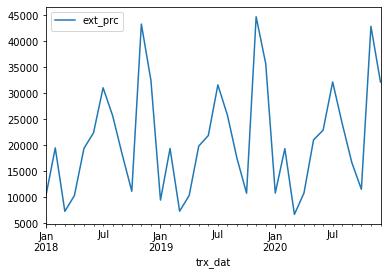

In [53]:
monthly_sales.plot()

In [54]:
customers_df['last_trx_dat'] = vi_sales_history[['customer_id', 'trx_dat']].groupby('customer_id').max()

## Review of Tables

In [55]:
products.head()

,brand,category,descr,id,msrp,unit_cost
0,1,1,Gentle Soap,1,10.0,5.0
1,1,1,Rejuvinating Soap,2,12.0,6.0
2,1,2,Moisturizing Lotion,3,12.0,6.0
3,2,1,All Clean Hand Soap,4,11.0,6.6
4,2,2,All Clean Hand Lotion,5,11.0,6.6


In [56]:
categories.head()

,descr,id
0,Soap,1
1,Lotion,2
2,Supplement,3


In [57]:
brands.head()

,descr,id
0,Bill's Soap Co.,1
1,Taysha's Health & Wellness,2
2,Treesap Naturals,3


In [58]:
vi_products.head()

,brand,category,descr,id,msrp,unit_cost,descr_brand,descr_categ
0,1,1,Gentle Soap,1,10.0,5.0,Bill's Soap Co.,Soap
1,1,1,Rejuvinating Soap,2,12.0,6.0,Bill's Soap Co.,Soap
2,2,1,All Clean Hand Soap,4,11.0,6.6,Taysha's Health & Wellness,Soap
3,1,2,Moisturizing Lotion,3,12.0,6.0,Bill's Soap Co.,Lotion
4,2,2,All Clean Hand Lotion,5,11.0,6.6,Taysha's Health & Wellness,Lotion


In [59]:
line_transactions.head()

,id,product_id,qty_sold
0,0,3,1
1,0,5,1
2,1,8,3
3,1,7,1
4,2,6,1


In [60]:
transactions.head()

,customer_id,id,month,trx_dat
0,1915,0,201801,2018-01-01
1,765,1,201801,2018-01-01
2,1295,2,201801,2018-01-01
3,543,3,201801,2018-01-01
4,252,4,201801,2018-01-01


In [61]:
states_df.columns = ['descr', 'id', 'region', 'division']
states_df.head()

,descr,id,region,division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [62]:
customers_df.head()

,id,first_name,last_name,state,last_trx_dat
0,0,Kenneth,Thompson,NJ,2020-07-01
1,1,Alexander,Thomas,AR,2020-12-01
2,2,Patrick,Brown,FL,2020-12-01
3,3,Eugene,Long,LA,2020-11-01
4,4,Melissa,Johnson,HI,2020-11-01


In [63]:
vi_sales_history.head()

,customer_id,id_trx,month,trx_dat,product_id,qty_sold,brand,category,descr,id_product,msrp,unit_cost,descr_brand,descr_categ,ext_prc
0,1915,0,201801,2018-01-01,3,1,1,2,Moisturizing Lotion,3,12.0,6.0,Bill's Soap Co.,Lotion,12.0
10023,1915,0,201801,2018-01-01,5,1,2,2,All Clean Hand Lotion,5,11.0,6.6,Taysha's Health & Wellness,Lotion,11.0
20116,765,1,201801,2018-01-01,7,1,2,3,Hempy Health Supplements,7,15.0,9.0,Taysha's Health & Wellness,Supplement,15.0
12997,765,1,201801,2018-01-01,8,3,3,2,Natural Cedar Lotion,8,12.0,6.0,Treesap Naturals,Lotion,36.0
30249,1295,2,201801,2018-01-01,2,1,1,1,Rejuvinating Soap,2,12.0,6.0,Bill's Soap Co.,Soap,12.0


## Conclusion

This simlulation produced the types of behaviors that a data analyst for a retail company would expect to see, minus one thing: trend. While the simulation produces realistic seasonalities and customer shopping habits, it does not allow for the growth of sales year-over-year.

However, the results are good enough to provide simlulated data for anyone looking to try out retail analytics. For a look at some of the results, check out the <a href="https://app.powerbi.com/view?r=eyJrIjoiZDNjMWY4ZmEtY2Y2Yi00NTMzLTlmZmYtZWM3NjkxOTY0YzRkIiwidCI6ImI1ZjZhZGJmLTVjY2YtNGJlMi04MDgzLWQ4ODY5YjBhNWE0MiIsImMiOjF9&pageName=ReportSection534c763a552cd144ea70">dashboard</a> I created that uses this data.